In [1]:
# CIL core components needed
from cil.framework import ImageGeometry, AcquisitionGeometry, BlockDataContainer, DataContainer, ImageData

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS, PDHG, SIRT, FISTA, HybridGLSQR, GLSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve
from cil.optimisation.operators import WaveletOperator, BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator
from cil.optimisation.functions import L2NormSquared, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation, LeastSquares

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Third-party imports
import numpy as np    
import matplotlib.pyplot as plt
import scipy.optimize as op

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import ZEISSDataReader

from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer

import matplotlib.pyplot as plt
import numpy as np
import os

# Data information

In this notebook, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

 - https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `filename` variable below.

In [2]:
#Update path to location of walnut dataset
filename = "/mnt/share-private/materials/SIRF/Fully3D/CIL/Walnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm"

## Load walnut data

In [3]:
# read the data
reader = ZEISSDataReader()
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra operator
data3D.reorder('astra')

# Select every 25 angles: less angles will make the need for regularization greater
sliced_data = Slicer(roi={'angle':(0,1601,25)})(data3D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2), 'vertical': (120, -120, 2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries
ag3D = data.geometry
ag3D.set_angles(ag3D.angles, initial_angle=0.2, angle_unit='radian')
ig3D = ag3D.get_ImageGeometry()

# Define projection operator
A = ProjectionOperator(ig3D, ag3D, device = "gpu")

# Check geometry
print(data)

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 65
	Angles 0-9 in radians: [-3.1415665, -3.0434484, -2.945264 , -2.847109 , -2.7489111, -2.6507533,
 -2.5525775, -2.454381 , -2.3561862, -2.257994 ]
	Angles 55-64 in radians: [2.2580016, 2.356183 , 2.4543426, 2.5525136, 2.6507554, 2.748842 ,
 2.8470535, 2.9452505, 3.0433784, 3.1415997]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (1024, 65, 1024)
New geometry shape:  (1024, 65, 10

# Inverse problems: LSQR, Tikhonov regularization, and hybrid methods

## LSQR with standard Tikhonov regularization

Next consider the Tikhonov regularized problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2 + \alpha^2 \begin{Vmatrix}u\end{Vmatrix}_2^2$$

where $\alpha$ is the regularization paramater and the regularization term is the norm of $u$.

The magnitude of the regularization parameter balances the goodness-of-fit to the data (the data fidelity term $\begin{Vmatrix}A u - b\end{Vmatrix}$) and the norm of the reconstructed image (the regularization term $\begin{Vmatrix}u\end{Vmatrix}$). Inclusion of the regularization term means that we hopefully don't fit to noise in the data, but only the high frequency components.

The traditional set-up in CIL is to re-write the regularized problem in block matrix form

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha I} u - \binom{b}{0}\end{Vmatrix}^2_2,$$

where $I$ is the identity operator.

With the definitions:

- $\tilde{A} = \binom{A}{\alpha I}$, 

- $\tilde{b} = \binom{b}{0}$

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

and being a least squares problem, it can be solved using LSQR with $\tilde{A}$ as operator and $\tilde{b}$ as data.

However, an important quality of LSQR is that regularize-then-project is equivalent to project-then-regularize. This means we don't have to define a block-operator and deal with higher memory costs throughout the iterative algorithm.

### Regularize-then-project = project-then-regularize

As previously described, when using LSQR on the un-regularized least squares problem, we define a small-dimensional problem with $B_k$ and solve that exactly. If we set out to solve
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2 + \alpha^2 \begin{Vmatrix}u\end{Vmatrix}_2^2,$$
one approach is the following:
1. Define $\tilde{A} = \binom{A}{\alpha I}$, $\tilde{b} = \binom{b}{0}$
2. Build the Krylov subspace associated to $\tilde{A}$ and $\tilde{b}\,$: $\,\mathcal{K}_k(\tilde{A}^T\tilde{A},\, \tilde{A}^T\tilde{b})$.
3. At each iteration, solve the subproblem
$$ u_k(\alpha) = \underset{u\in\mathcal{K}_k(\tilde{A}^T\tilde{A},\, \tilde{A}^T\tilde{b})}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2.$$
Alternatively, one may
1. Build the Krylov subspace associated to $A$ and $b\,$: $\,\mathcal{K}_k(A^TA,\, A^Tb)$.
2. At each iteration, solve the subproblem
\begin{equation*}
    u_k(\alpha) = \underset{u\in\mathcal{K}_k(A^TA,\, A^Tb)}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2.
\end{equation*}
by solving
\begin{equation*}
    \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}\begin{bmatrix}B_k \\ \alpha I \end{bmatrix}y - \|b\|e_1 \end{Vmatrix}_2^2,
\end{equation*}
where $B_k$ is the bidiagonal matrix as before.

The upside is that we work with smaller vectors throughout, reducing the computational effort and memory cost. The adaption to the code is minimal, as can be seen from the code excerpt below.


# Choosing a good regularization parameter

The previous figure shows us that the regularization parameter $\alpha = 1.5$ is probably too large, as the reconstruction gets a bit too smooth and loses details. It is difficult to predict a good regularization parameter $\alpha$ a priori. Let's investigate the reconstruction for a couple of different parameters. We use LSQR for the reconstructions, where we simply pass the regularization parameter to LSQR:

\begin{align*}
&\texttt{lsqr = LSQR(operator=A, data=data, alpha=alpha)} \\
&\texttt{lsqr.run(iterations=maxit, verbose=True)}
\end{align*}

From a visual inspection, it seems that the optimal regularization parameter is around $\alpha \in (0.5,1)$. For smaller values of $\alpha$, artefacts are present in the reconstruction. For greater values of $\alpha$, the reconstruction is over-smoothed. Can we find a good value of $\alpha$ without computing doing lots of reconstructions?


# Hybrid Krylov subspace methods

We set out to estimate a good parameter without computing various reconstructions. We will resort to hybrid Krylov subspace methods for this.

As previously explained, within LSQR, at the $k$-iteration we have made the approximation:

\begin{equation*}
    \underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 \approx \underset{u\in\mathcal{K}_k(A^TA,\,A^Tb)}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 =: x_k
\end{equation*}    

and we have simplified this to
\begin{equation*}    
    y_k = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}, \quad x_k = V_ky_k,
\end{equation*}
where $B_k$ is the bidiagonal matrix as before and $V_k$ is the orthonormal basis for the $k$-dimensional Krylov subspace $\mathcal{K}_k(A^TA,\,A^Tb)$.

Now, if we include Tikhonov regularization, setting out the solve 
\begin{equation*}
    \underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2 \approx \underset{u\in\mathcal{K}_k(A^TA,\,A^Tb)}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2 =: x_k(\alpha),
\end{equation*}    

we find the simplified subproblem
\begin{equation*}    
    y_k(\alpha) = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}_2^2 + \alpha^2\|y\|_2^2 = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}\begin{bmatrix}B_k \\ \alpha I\end{bmatrix} y - \|b\|e_1\end{Vmatrix}_2^2, \quad x_k(\alpha) = V_ky_k(\alpha)
\end{equation*}

In a hybrid method, we use an automatic regularization parameter selection rule at  the small(!) subproblem

## Automatic regularization parameter selection


We will first introduce some automatic regularization parameter rules. We introduce them for the full problem 
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2,$$
to build intuition. Then we introduce the computational cost associated to applying the rule to the small projected problem
$$ \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}_2^2 + \alpha^2\|y\|_2^2.$$

### Discrepency principle

The discrepency principle requires an estimate of the magnitude of the noise $\|\eta\|$ as input. It then seeks to find a regularized solution such that:
$$\|Au(\alpha)-b\|_2^2 = \tau \|\eta\|_2^2,$$
where $\tau$ is some small safety parameter. Computing such an $\alpha$ for the full problem with $A$ is computationally infeasible, as it would require either computing many solutions $u(\alpha)$ for different values of $\alpha$ or the singular value decomposition (SVD) of $A$. This is why we apply the discrepency principle to the small projected problem.

In our hybrid scheme, we have at an iteration $k$ that 
$$y_k(\alpha) = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}_2^2 + \alpha^2\|y\|_2^2.$$
We then find the associated regularization parameter $\alpha_k$, we must solve
$$\mathrm{find}\,\, \alpha_k\, \, \mathrm{such\,\, that} \begin{Vmatrix}B_ky_k(\lambda_k) - \|b\|e_1\end{Vmatrix}_2^2 = \tau \|\eta\|_2^2.$$
If we have a singular value decomposition $$B_k = P_k\begin{bmatrix}\Sigma_k \\ 0 \end{bmatrix} Q_k^T,$$ then $y_k(\lambda)$ can be expressed as
$$y_k(\lambda) = \|b\|Q_k(\Sigma_B^2 + \alpha^2 I)^{-1}\Sigma_B P_{:,1:k}^Te_1,$$
so we find $\alpha\geq 0$ that satisfies
$$\tau \|\eta\|_2^2 = \|b\|_2^2\left(\left\|\alpha^2(\Sigma_k^2 + \alpha^2I)^{-1}P_{:,1:k}^Te_1 \right\|_2^2 + \left\|p_{k+1}^Te_1 \right\|_2^2\right).$$
This root-finding problem is solved with $\texttt{scipy.optimize.root\_scalar}$ and target function
$$f(\alpha) = \|b\|_2^2\left(\left\|\alpha^2(\Sigma_k^2 + \alpha^2I)^{-1}P_{:,1:k}^Te_1 \right\|_2^2 + \left\|p_{k+1}^Te_1 \right\|_2^2\right)  - \tau \|\eta\|_2^2.$$
This root-finding problem is solved at every iteration, as the singular value decomposition of $B_k$ is updated. This gives us a sequence of regularization parameters $\alpha_1,\dots, \alpha_k$. We state that the parameter has converged at iteration $k$ if 
$$ \frac{|\alpha_k - \alpha_{k-1}|}{\alpha_k} < \texttt{tol}_{\alpha},$$
where the tolerance $\texttt{tol}_{\alpha}$ is a user-input.


### Generalized Cross-Validation: standard, weighted, and adaptive

Cross validation is a data fitting technique that aims to minimise noise-effects by fiting to a subset of the data, and ensuring the fit is good on an unseen subset of the data. Generalized cross validation (GCV) is a rotation-invariant version of ordinary cross validation, employing a leave-one-out prediction method (see Golub, Heath, and Wahba, 1979). We set out to minimize the GCV function
$$G(\alpha) = \frac{\|Au(\alpha) - b\|_2^2}{\textrm{trace}\,(I - AA_{\alpha}^{\#})},$$
where $A_{\alpha}^{\#}$ is the ``regularized inverse'' given by $A_{\alpha}^{\#}(A^TA + \alpha^2I)^{-1}A^T$. 

Again, computing the minimizer $\alpha^*$ of $G(\alpha)$ is computationally infeasible as it requires the SVD of $A$. We instead minimize the GCV function associated to the projected problem with $B_k$. Again, let $$B_k = P_k\begin{bmatrix}\Sigma_k \\ 0 \end{bmatrix} Q_k^T$$ be an SVD and let $p_i$ denote the columns of $P_k$ and $\sigma_i$ the singular values in $\Sigma_k$. Then
\begin{align*}
G_k(\alpha) &= \frac{\|B_ky(\alpha) - \|b\|e_1\|_2^2}{\textrm{trace}\,(I - B_kB_{k,\alpha}^{\#})}\\
&= k\|b\|^2\frac{\left(\sum_{i=1}^k\left(\frac{\alpha^2p_i^Te_1}{\sigma_i^2+\alpha^2}\right)^2 + (p_{k+1}^Te_1)^2\right)} {\left(1 + \sum_{i=1}^k \frac{\alpha^2}{\sigma_i^2 + \alpha^2}\right)^2}.
\end{align*}
Standard GCV minimizes this functional using $\texttt{scipy.optimize.fmin}$.

Chung, Nagy, and O'Leary (2008) report that GCV sometimes underperforms, exhibiting semiconvergent behaviour. They propose a weighted GCV (W-GCV) method, with W-GCV function
$$G(\omega, \alpha) = \frac{\|Au(\alpha) - b\|_2^2}{\textrm{trace}\,(I - \omega AA_{\alpha}^{\#})}.$$
For the projected problem, the W-GCV function has the form
\begin{equation*}
G_k(\omega, \alpha) = k\|b\|^2\frac{\left(\sum_{i=1}^k\left(\frac{\alpha^2p_i^Te_1}{\sigma_i^2+\alpha^2}\right)^2 + (p_{k+1}^Te_1)^2\right)} {\left(1 + \sum_{i=1}^k \frac{(1-\omega)\sigma_i^2 + \alpha^2}{\sigma_i^2 + \alpha^2}\right)^2}.
\end{equation*}
It is not clear how to choose a good value for $\omega$. For this reason, Chung, Nagy, and O'Leary (2008) introduce an adaptive W-GCV method, where $\omega$ is chosen adaptively and is updated at every iteration. We next explain this adaptive procedure. 

In early iterations, the projected problem with $B_k$ is meant to capture the high-frequency components of $A$. We assume that little or no regularization is necessary here, and thus that the optimal regularization parameter $\alpha_k^*$ should satisfy
$$0\leq \alpha_k^* \leq \sigma_{\min}(B_k),$$
where $\sigma_{\min}(B_k)$ is the smallest singular value of $B_k$. If we assume that the optimal parameter is exacly $\sigma_{\min}(B_k)$, then we can find the optimal $\omega_k^*$ by ensuring
$$\textrm{find}\,\,\omega_k^* \,\, \textrm{such\,\, that}\,\, \frac{\delta}{\delta \alpha}G_k(\omega_k^*, \alpha)\vert_{\lambda = \sigma_{\min}(B_k)} = 0$$
We call the $\omega$ found with this root-finding problem $\hat{\omega}_k$. If $\sigma_{\min}(B_k)$ is greater than some tolerance $\texttt{tol}_{\sigma}$, then $\omega_k = \hat{\omega}_k$.

In later iterations, $B_k$ will inheret more and more of the ill-conditioning present in $A$. As a result, we would likely need 
$$\alpha_k^* > \sigma_{\min}(B_k).$$
For these iterations, where $\texttt{tol}_{\sigma} \geq \sigma_{\min}(B_k)$ we take,
$$\omega_k = \textrm{mean}\,\{\hat{\omega}_1,\dots,\hat{\omega}_k\}.$$

There are two simultaneous stopping criteria suggested in Chung, Nagy, and O'Leary (2008). For either, we define a new GCV function that combines $G$ and $G_k$. Define
$$\hat{G}(k) = n\|b\|^2\frac{\left(\sum_{i=1}^k\left(\frac{\alpha_k^2p_i^Te_1}{\sigma_i^2+\alpha_k^2}\right)^2 + (p_{k+1}^Te_1)^2\right)} {\left((m-k) + \sum_{i=1}^k \frac{\alpha_k^2}{\sigma_i^2 + \alpha_k^2}\right)^2},$$
where $m\times n$ are the dimensions of $A$. 

The first stopping criterium is to stop when the function $\hat{G}$ changes very little:
$$ \frac{|\hat{G}(k) - \hat{G}(k-1)|}{|\hat{G}(1)|} < \texttt{tol}_{G},$$
where the tolerance $\texttt{tol}_{G}$ is a user-input. The second is to stop when then GCV values $\hat{G}(k)$ start to increase. Then, we stop at iteration $k_0$ for which
$$k_0 = \mathrm{argmin}\,\hat{G}(k),$$
and set $\alpha = \alpha_{k_0}$.


There exist a scala of automatic regularization parameter methods. Prominent methods include the L-curve rule, unbiased predictive rule, and the Reginska criterion. These methods require implementation. Details can be found in Gazzola and Sabate Landman (2020). 

## Hybrid methods in action Tikhonov Regularization

1. Discrepency
2. GCV
3. Weighted GCV
4. Adaptive Weighted GCV
5. L-curve


In [4]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-3
maxit = 500
initial = A.domain_geometry().allocate(0)

## 1. Discrepency Rule

In [5]:
# Let's say 10% noise
noiselevel = 0.15 * data.norm()
discrep_rule = UpdateRegDiscrep(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_level_estimate=noiselevel)

hybridlsqrD = HybridGLSQR(operator=A, data=data, initial=initial,
                          maxoutit=maxit,
                         reg_norm_type='L2', hybrid_reg_rule=discrep_rule)
hybridlsqrD.run(maxit, verbose=True)


  0%|          | 0/500 [00:00<?, ?it/s]

The optimal parameter it finds is 1.5652928853110348 in 19 iterations


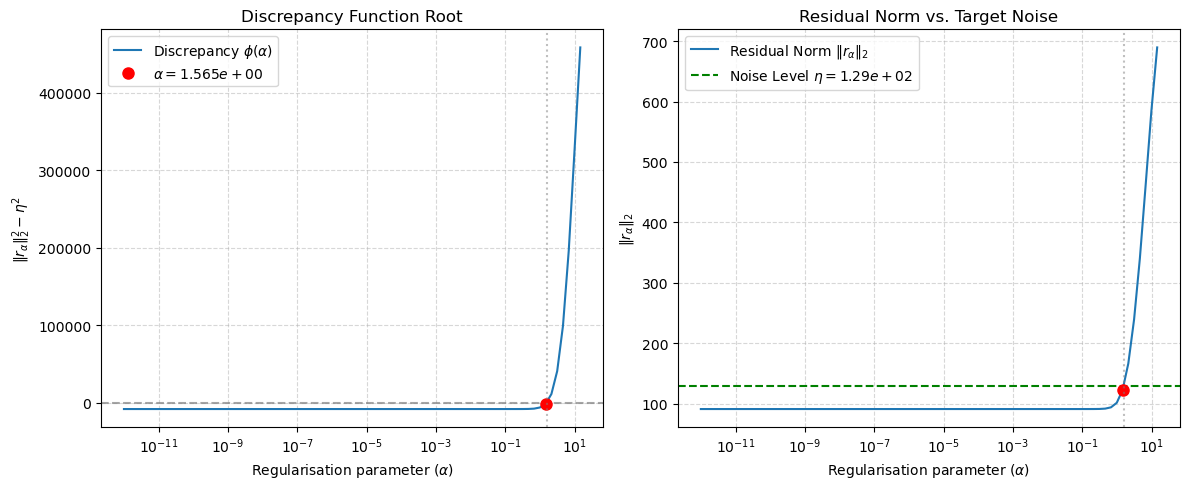

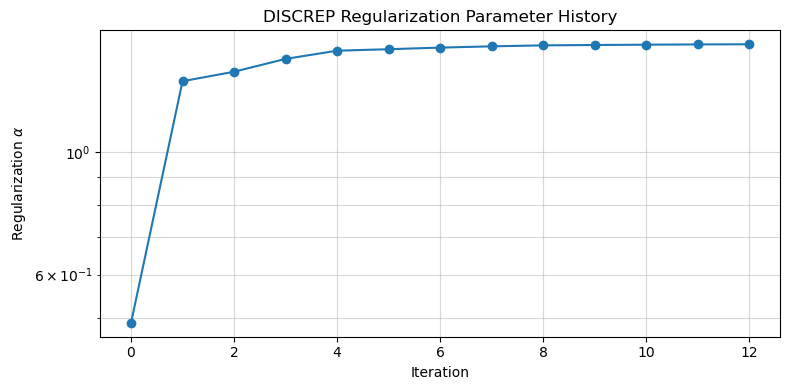

In [6]:
print("The optimal parameter it finds is", hybridlsqrD.regalpha, "in", hybridlsqrD.iteration, "iterations")

hybridlsqrD.reg_rule.plot_function()
hybridlsqrD.reg_rule.plot_history()

## 2. Standard GCV Rule

In [7]:
gcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                adaptive_weight=False)

hybridlsqrgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                         reg_norm_type='L2', hybrid_reg_rule=gcv_rule)
hybridlsqrgcv.run(maxit, verbose=True)

  0%|          | 0/500 [00:00<?, ?it/s]

The optimal parameter it finds is 1.6180542746028428 in 10 iterations


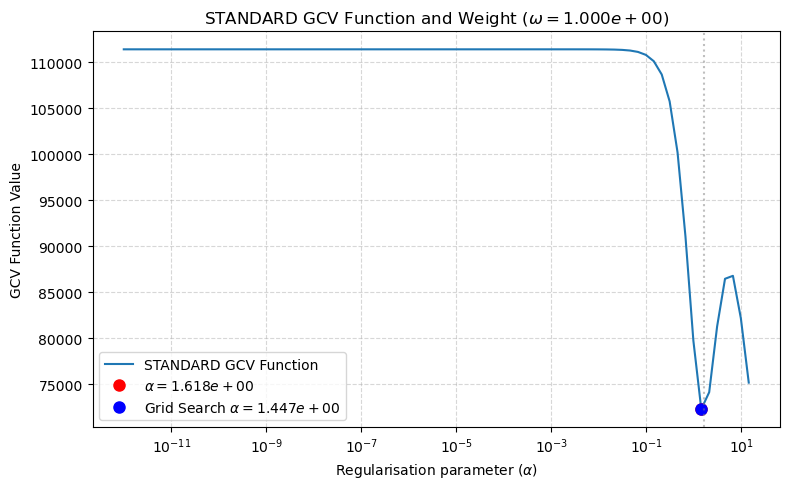

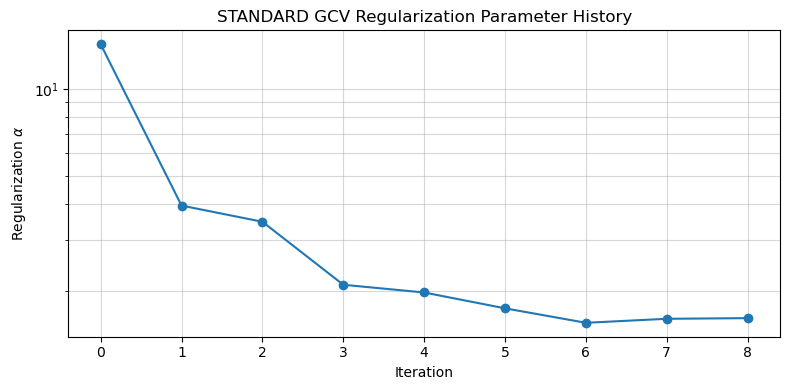

In [8]:
print("The optimal parameter it finds is", hybridlsqrgcv.regalpha, "in", hybridlsqrgcv.iteration, "iterations")

hybridlsqrgcv.reg_rule.plot_function()
hybridlsqrgcv.reg_rule.plot_history()

## 3. Weighted GCV Rule

In [9]:
wgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=False)

hybridlsqrwgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                         reg_norm_type='L2', hybrid_reg_rule=wgcv_rule)
hybridlsqrwgcv.run(maxit, verbose=True)

  0%|          | 0/500 [00:00<?, ?it/s]

The optimal parameter it finds is 0.5084639680609264 in 16 iterations


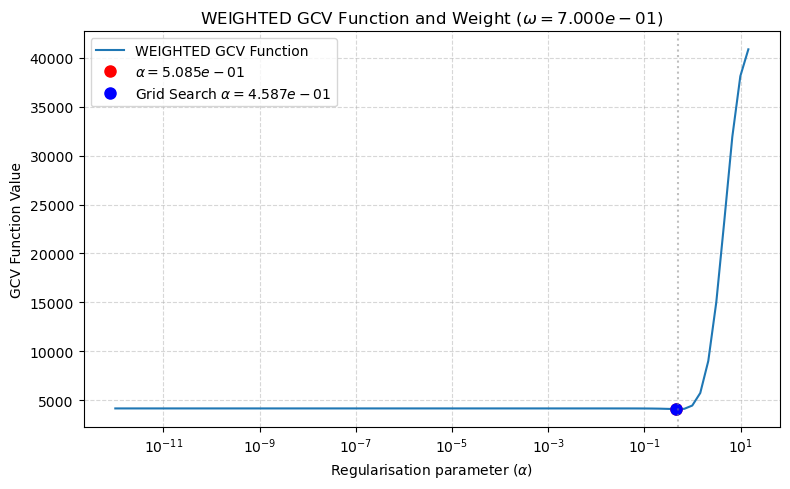

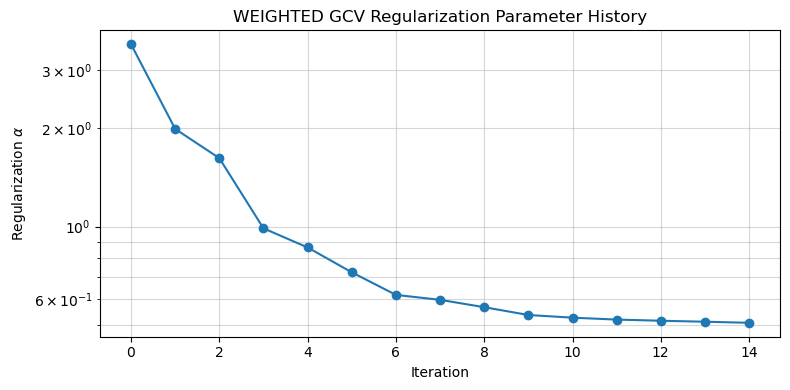

In [10]:
print("The optimal parameter it finds is", hybridlsqrwgcv.regalpha, "in", hybridlsqrwgcv.iteration, "iterations")

hybridlsqrwgcv.reg_rule.plot_function()
hybridlsqrwgcv.reg_rule.plot_history()

## 4. Adaptive-Weighted GCV Rule

In [11]:
awgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=True)

hybridlsqrawgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                         reg_norm_type='L2', hybrid_reg_rule=awgcv_rule)
hybridlsqrawgcv.run(maxit, verbose=True)

  0%|          | 0/500 [00:00<?, ?it/s]

The optimal parameter it finds is 0.6991644803727621 in 12 iterations


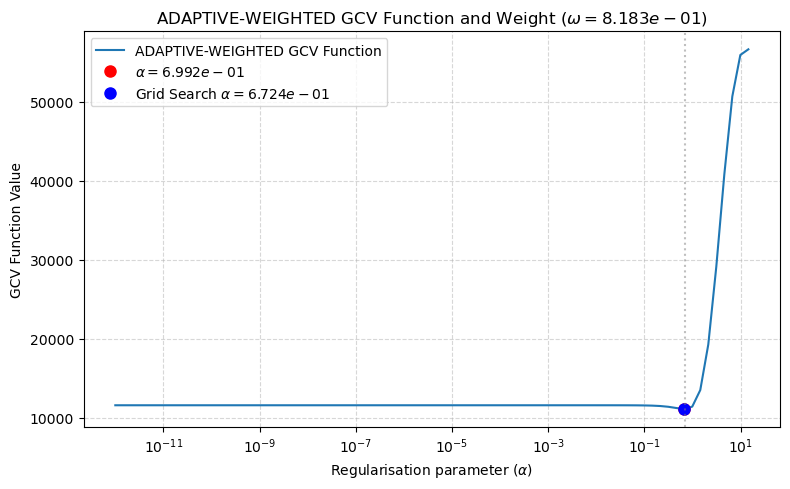

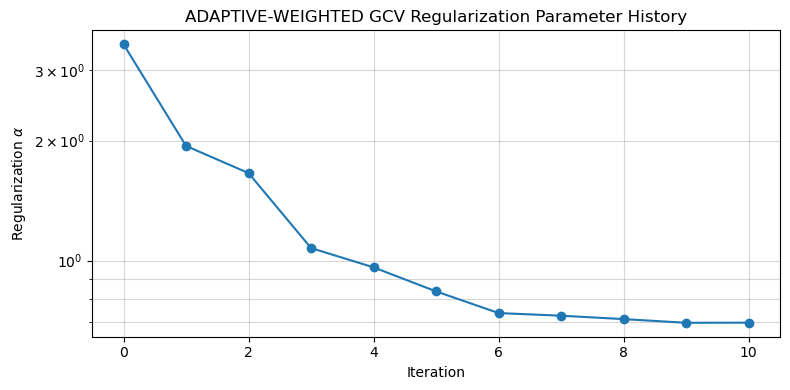

In [12]:
print("The optimal parameter it finds is", hybridlsqrawgcv.regalpha, "in", hybridlsqrawgcv.iteration, "iterations")

hybridlsqrawgcv.reg_rule.plot_function()
hybridlsqrawgcv.reg_rule.plot_history()

## 5. L-curve Rule

Next we use generalized cross validation

In [13]:
alpha_tol = 1e-4
maxit = 50
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                         reg_norm_type='L2', hybrid_reg_rule=lcurve_rule)
hybridlsqrlcurve.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 0.5127186231458204 in 50 iterations


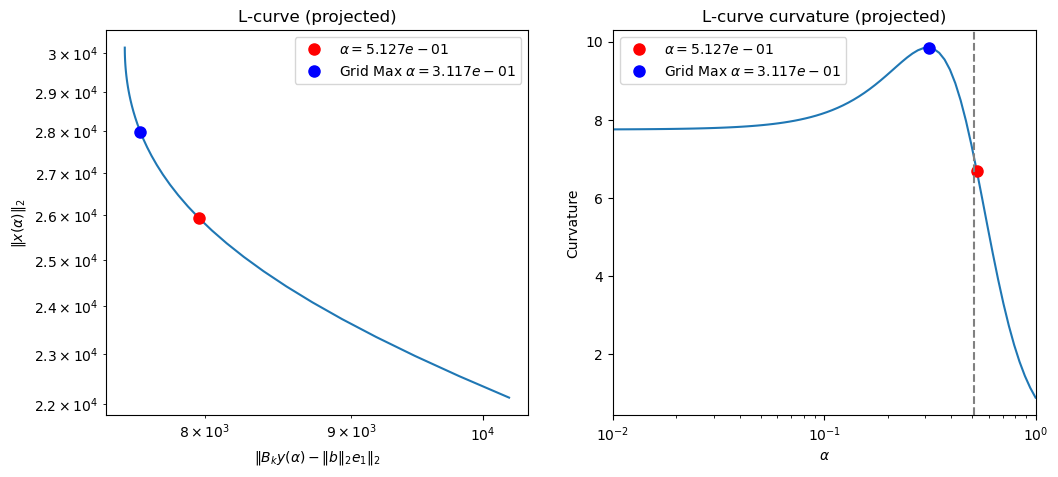

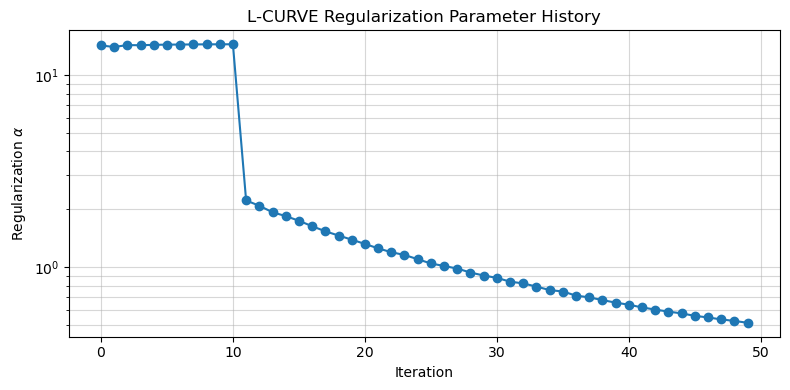

In [19]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-2, 1))
hybridlsqrlcurve.reg_rule.plot_history()

In [15]:
lsqrd = GLSQR(operator=A, data=data, regalpha = hybridlsqrD.regalpha)
lsqrd.run(hybridlsqrD.iteration, verbose=True)

lsqrgcv = GLSQR(operator=A, data=data, regalpha = hybridlsqrgcv.regalpha)
lsqrgcv.run(hybridlsqrgcv.iteration, verbose=True)

lsqrwgcv = GLSQR(operator=A, data=data, regalpha = hybridlsqrwgcv.regalpha)
lsqrwgcv.run(hybridlsqrwgcv.iteration, verbose=True)

lsqrawgcv = GLSQR(operator=A, data=data, regalpha = hybridlsqrawgcv.regalpha)
lsqrawgcv.run(hybridlsqrawgcv.iteration, verbose=True)

lsqrlcurve = GLSQR(operator=A, data=data, regalpha = hybridlsqrlcurve.regalpha)
lsqrlcurve.run(hybridlsqrlcurve.iteration, verbose=True)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The results are shown in the figure below. 

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once
solutions = [
    lsqrd.solution, 
    lsqrgcv.solution, 
    lsqrwgcv.solution, 
    lsqrawgcv.solution, 
    lsqrlcurve.solution
]

titles = [
    f'Discrep alpha = {hybridlsqrD.regalpha:.2e}',
    f'GCV alpha = {hybridlsqrgcv.regalpha:.2e}', 
    f'WGCV alpha = {hybridlsqrwgcv.regalpha:.2e}', 
    f'AWGCV alpha = {hybridlsqrawgcv.regalpha:.2e}',
    f'LCURVE alpha = {hybridlsqrlcurve.regalpha:.2e}',
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    'Discrepancy': 0,
    'GCV': 1,
    'WGCV': 2,
    'AWGCV': 3,
    'L-Curve': 4
}

def update_display(vslice, rule_name,norm_name='L2'):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 3
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        fix_range=(0, 0.05), 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Hybrid GLSQR Analysis {norm_name}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display, 
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=200, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value='All Rules', description='Rule:')
);

interactive(children=(IntSlider(value=200, description='Slice:', max=391), Dropdown(description='Rule:', optio…

Some rules seem to result in quite reasonable parameters, while others oversmoothe. 

## Non-standard Tikhonov regularization

We are often interested in solving the problem with non-standard L2 regularization:
$$\underset{u}{\mathrm{min}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|Lu\|_2^2,$$
where $L$ is some kind of operator on the image $u$, usually a gradient/finite difference or wavelet operator. Under no assumptions on the shape regularity of $L$, this problem is equivalent to (Chung and Gazzola, 2024)
$$\bar{x}(\alpha) = \underset{\bar{x}}{\mathrm{argmin}}\begin{Vmatrix}AL_A^{\dagger}\bar{x} - \bar{b}\end{Vmatrix}_2^2 + \alpha^2\|\bar{x}\|_2^2,$$
where
- $L_A^{\dagger}$ is the $A$-weighted generalized inverse of $L$: $L_A^{\dagger} = (I -(A(I-L^{\dagger}L^{\dagger}))^{\dagger}A)L^{\dagger}$.
- $u(\alpha) = L_A^{\dagger}\bar{x}(\lambda) + u_0^L$
- $\bar{b} = b - u_0^L$
- $u_0^L$ is the component of the regularized solution $u(\lambda)$ in the null space of $L$. 

If $L$ is invertible, then $L_A^{\dagger} = L^{-1}$ and if $L$ is full column rank, then $L_A^{\dagger} = L^{\dagger}$. In either of these cases, in every iteration of Golub-Kahan bidiagonalization we must solve a linear system with $L$.